# Library Imports for 3D Medical Imaging Pipeline

This section imports all necessary libraries for the complete 3D medical image analysis workflow, organized according to PEP 8 standards:

**Standard Library**: Core Python functionality  
**Third-party Libraries**: External packages for computer vision, deep learning, scientific computing, and medical imaging  
**Specialized Modules**: Specific functions for image processing, morphological operations, and neural network components  

The imports support the full pipeline from CT data loading and segmentation through 3D model conversion to deep feature analysis and visualization.

In [26]:
# Standard library imports
import cv2

# Third-party library imports
import matplotlib.pyplot as plt
import mayavi as mlab
import nibabel as nib
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models

# Specialized imports - scipy
from scipy.ndimage import (
    binary_fill_holes,
    distance_transform_edt,
    label,
    zoom
)

# Specialized imports - skimage
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from skimage.measure import regionprops
from skimage.morphology import (
    binary_opening,
    disk,
    remove_small_objects
)
from skimage.segmentation import watershed

# CT Volume Segmentation Implementation

This implementation performs automated bone segmentation from CT scan data using a multi-step image processing pipeline:

1. **Volume Loading**: Loads 3D CT volume data from NIfTI format using nibabel
2. **Slice Processing**: Processes individual 2D slices with upsampling, Gaussian blur, and thresholding
3. **Morphological Operations**: Applies hole filling, opening, and small object removal to clean masks
4. **Blob Separation**: Uses watershed algorithm with distance transform to separate connected bone regions
5. **Region Selection**: Retains only the largest segmented region per slice to isolate primary bone structure
6. **Volume Reconstruction**: Combines processed slices into final 3D binary mask
7. **Visualization**: Displays sample slices to verify segmentation quality

The pipeline is optimized for knee bone segmentation with configurable parameters for threshold values, minimum object sizes, and processing ranges.

Semi Automated Mask Generation

- **1. For each slice x such that 0 <= x < 90, threshold(240) and min_size(800)**
- **2. For each slice x such that 90 <= x < 94, remove blobs(top 1 feature), threshold(160) and min_size(800)**
- **3. For each slice x such that 94 <= x < 103, threshold(180) and min_size(800)**
- **4. For slice x such that x == 103, threshold(280) and min_size(800)**
- **5. For each slice x such that 104 <= x < 108, threshold(130) and min_size(60)**
- **6. For each slice x such that 108 <= x < 130, threshold(180) and min_size(1200)**
- **7. For each slice x such that x >= 130, threshold(240) and min_size(800)**

**Note: For background mask generation, use threshold(-100) and min_size(800)**

In [ ]:
# Load CT volume data from NIfTI file
volume = nib.load("../datasets/3702_left_knee_bone_mask.nii.gz")
data = volume.get_fdata()

In [ ]:
# Initialize binary mask array with same dimensions as input volume
binary_mask = np.zeros_like(data)

In [198]:
def mask_slice(i, threshold_value=240, min_size=800, zoom_factor=4, sigma=2):
    """
    Create a binary mask for a specific slice index in the CT volume.

    Parameters:
        i (int): Slice index to process.
        threshold_value (int): Intensity threshold for binarization.
        sigma (float): Gaussian blur sigma value.
        zoom_factor (int or float): Factor to zoom in before processing.

    Returns:
        np.ndarray: A binary mask for the given slice.
    """
    # Extract the slice
    slice = data[:, :, i]

    # Upsample to improve resolution for thresholding
    zoom_in = zoom(slice, (zoom_factor, zoom_factor), order=0)

    # Apply Gaussian blur to reduce noise
    blurred = gaussian(zoom_in, sigma=sigma)

    # Thresholding to create binary mask
    _, thresh = cv2.threshold(blurred, threshold_value, 255, cv2.THRESH_BINARY)

    # Downsample to original shape
    zoom_out = zoom(thresh, (1/zoom_factor, 1/zoom_factor), order=0)

    # Fill internal holes
    filled_mask = binary_fill_holes(zoom_out)

    # Optional: Apply morphological opening to remove small artifacts
    opening = binary_opening(filled_mask, disk(1), mode="ignore")

    # Remove small objects to clean up the mask
    clean_mask = remove_small_objects(opening.astype(bool), min_size=min_size)

    return clean_mask


In [129]:
def remove_blobs(clean_mask):

    # Distance transform and peak detection
    distance = distance_transform_edt(clean_mask)
    coords = peak_local_max(distance, labels=clean_mask, footprint=np.ones((10, 10)), min_distance=25)
    
    # Label the peaks
    markers = np.zeros_like(distance, dtype=bool)
    markers[tuple(coords.T)] = True
    markers, _ = label(markers)

    # Watershed to separate loosely connected regions
    labels_ws = watershed(-distance, markers, mask=clean_mask)

    output_mask = np.zeros_like(clean_mask, dtype=bool)
    for region in sorted(regionprops(labels_ws), key=lambda r: r.area, reverse=True)[:1]:
        output_mask[labels_ws == region.label] = True

    return output_mask
    

In [ ]:
# Process slices in specified range with given parameters
def process_slices(start, end, threshold_value, min_size):

    for i in range(start, end):
        
        # Generate mask from the slice
        clean_mask = mask_slice(i, threshold_value, min_size)

        # Separate connected regions and keep largest
        output_mask = remove_blobs(clean_mask)

        # Store the mask in the binary volume
        binary_mask[:, :, i] = output_mask.astype(np.uint8)


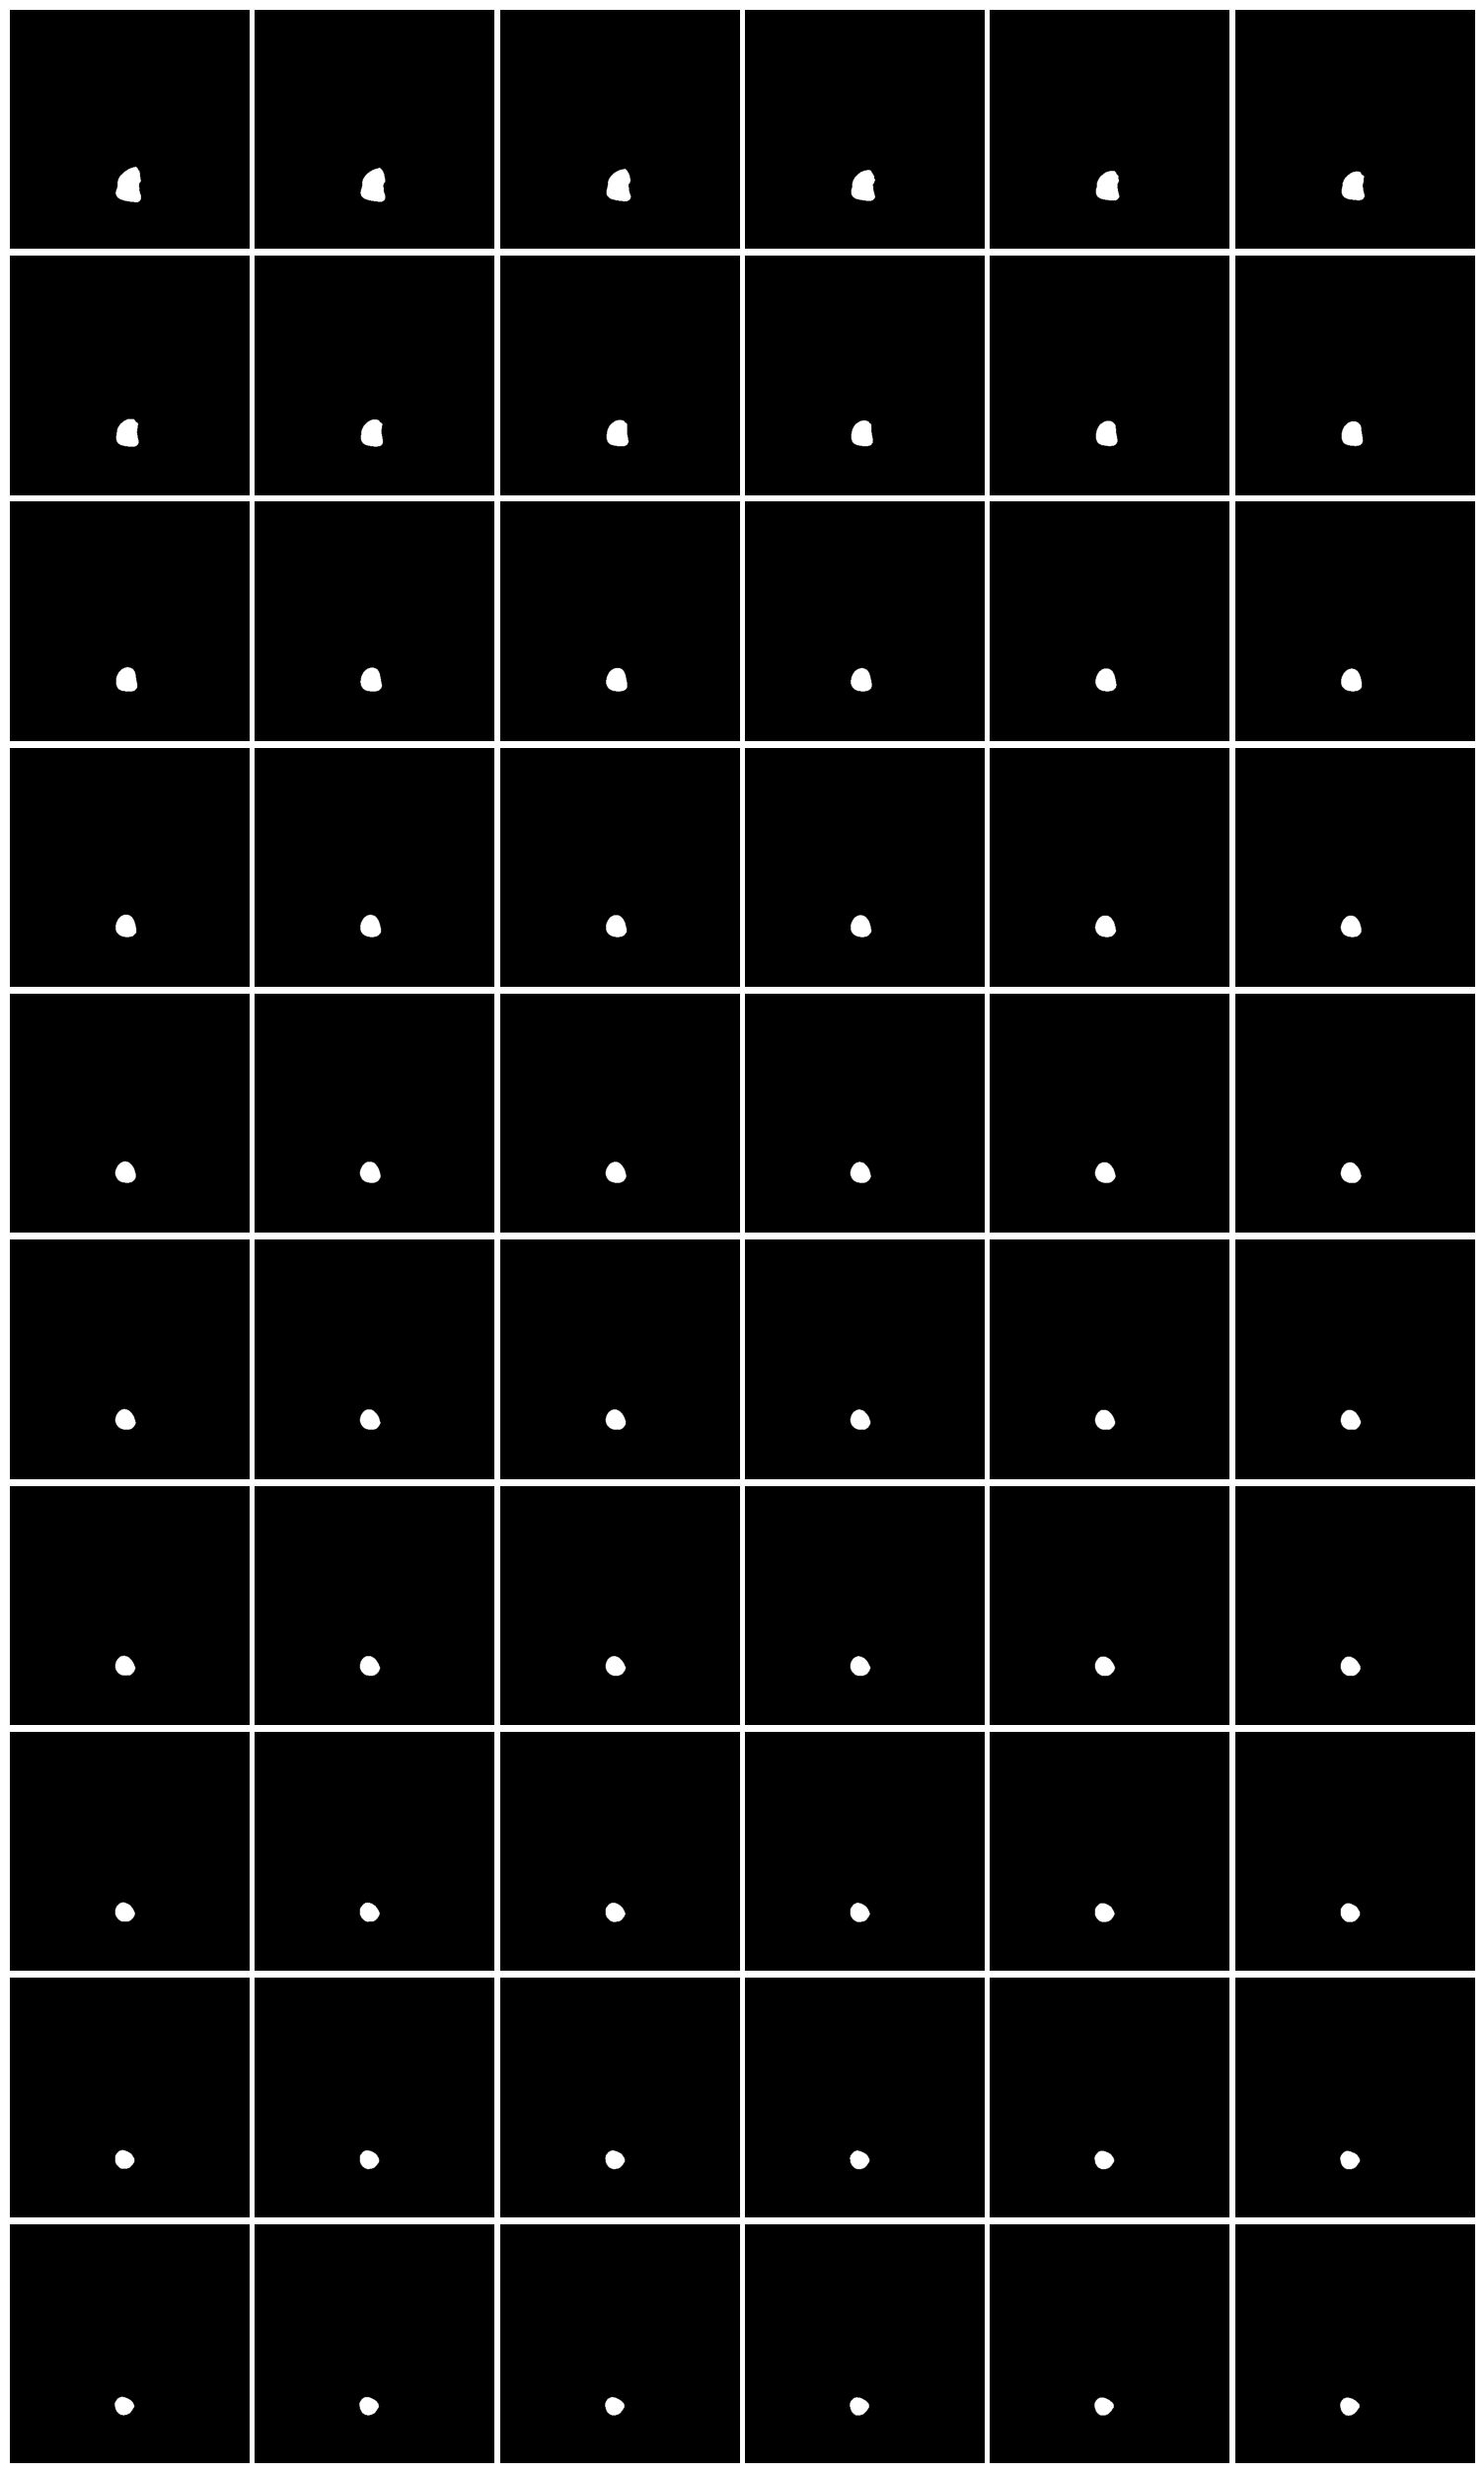

In [ ]:
# Visualize segmentation results for quality assessment
# Display 60 consecutive slices starting from slice 130
fig, axes = plt.subplots(10, 6, figsize=(15, 25))
for i, ax in enumerate(axes.flat):
    ax.imshow(binary_mask[:, :, 130 + i], cmap="gray")
    ax.axis("off")  # Remove axis labels for cleaner visualization
plt.tight_layout(pad=0.5)
plt.show()

# 3D Watershed Segmentation and Visualization

This implementation performs 3D watershed segmentation on CT volume data and creates multi-modal visualizations:

1. **Data Loading**: Loads CT bone mask and background mask volumes from NIfTI files
2. **3D Watershed**: Applies distance transform-based watershed segmentation to separate bone regions in 3D space
3. **Marker Detection**: Uses local maxima in distance field as watershed seeds with large 3D footprint (100³)
4. **Label Assignment**: Creates distinct labels for separated bone components via watershed algorithm
5. **3D Visualization**: Renders segmented volumes using Mayavi for interactive 3D exploration
6. **RGB Volume Creation**: Constructs color-coded volume (gray background, green/red bone regions)
7. **Tensor Conversion**: Transforms volume to PyTorch tensor format for deep learning compatibility
8. **2D Slice Display**: Extracts and visualizes individual RGB slices for quality assessment

In [ ]:
# Load CT bone mask volume
ct_volume = nib.load("../datasets/3702_left_knee_bone_mask.nii.gz")
ct_data = ct_volume.get_fdata()

In [ ]:
# Load background mask volume
bg_volume = nib.load("../datasets/3702_left_knee_bg_mask.nii.gz")
bg_data = bg_volume.get_fdata().astype(np.uint8)

In [ ]:
def watershed_segmentation(volume):
    """
    Applies 3D watershed segmentation to a binary volume using distance transform and local maxima.

    Parameters:
    - volume (np.ndarray): A 3D binary mask volume.

    Returns:
    - labels (np.ndarray): A 3D array of watershed-labeled regions.
    """
    # Ensure input is boolean
    binary_volume = volume.astype(bool)
    
    # Compute the Euclidean distance transform
    distance = distance_transform_edt(binary_volume)
    
    # Detect local maxima to serve as markers
    coordinates = peak_local_max(
        distance,
        footprint=np.ones((100, 100, 100)),
        labels=binary_volume,
        exclude_border=False
    )
    
    # Create marker image
    marker_mask = np.zeros(distance.shape, dtype=bool)
    marker_mask[tuple(coordinates.T)] = True
    
    # Label the markers
    markers, _ = label(marker_mask)
    
    # Apply the watershed algorithm
    labels = watershed(-distance, markers, mask=binary_volume)
    
    return labels


In [ ]:
# Prepare 3D volume for watershed segmentation
volume_3d = np.stack(ct_data, axis=0)

In [ ]:
# Apply 3D watershed segmentation to separate bone regions
labels = watershed_segmentation(volume_3d)

In [ ]:
# Visualize original volume in 3D using Mayavi
mlab.contour3d(volume_3d, color=(1,1,1))
mlab.show()

In [ ]:
# Create RGB volume for color-coded visualization
volume_rgb = np.zeros((512, 512, 216, 3), dtype=np.uint8)

# Assign colors: gray for background, green/red for different bone regions
volume_rgb[bg_data == 128] = [128, 128, 128]
volume_rgb[labels == 1] = [0, 255, 0]
volume_rgb[labels == 2] = [255, 0, 0]

In [ ]:
# Visualize specific labeled region (label 2) in 3D
mlab.contour3d((labels == 2).astype(np.uint8), color=(0, 1, 0), opacity=0.5)
mlab.show()

In [ ]:
# Normalize RGB values to [0,1] range for tensor operations
volume_rgb = volume_rgb.astype(np.float32) / 255.0

In [ ]:
# Convert to PyTorch tensor with channel-first format (C, D, H, W)
tensor_3d = torch.from_numpy(volume_rgb).permute(3, 2, 0, 1)
tensor_3d.shape

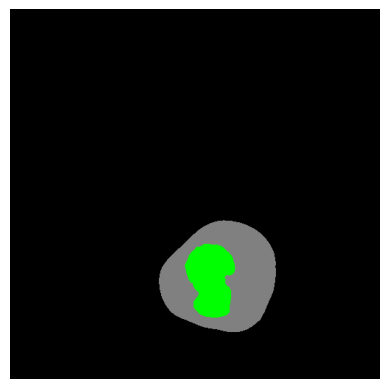

In [22]:
# Extract and display a single RGB slice for quality check
rgb_slice = tensor_3d[:, 100, :, :]
rgb_slice_np = rgb_slice.permute(1, 2, 0).numpy()
plt.imshow(rgb_slice_np)
plt.axis("off")
plt.show()

# DenseNet121 2D-to-3D Model Inflation

This implementation converts a pretrained 2D DenseNet121 model to handle 3D volumetric data through layer inflation:

1. **Pretrained Loading**: Loads DenseNet121 with ImageNet weights and removes the classification head
2. **Conv2D Inflation**: Expands 2D convolution kernels to 3D by replicating weights across depth dimension
3. **BatchNorm Inflation**: Converts 2D batch normalization layers to 3D equivalents while preserving statistics
4. **Pooling Inflation**: Transforms 2D max/average pooling operations to their 3D counterparts
5. **Weight Initialization**: Averages inflated 3D weights by depth to maintain feature magnitude consistency
6. **Recursive Conversion**: Traverses the entire model architecture to convert all compatible layers
7. **Parameter Transfer**: Preserves pretrained weights and running statistics during the inflation process
8. **3D Model Output**: Produces a fully functional 3D CNN capable of processing volumetric medical data

In [ ]:
# Load pretrained DenseNet121 and remove classification head for feature extraction
model_2d = models.densenet121(pretrained=True)
model_2d.classifier = nn.Identity()

d:\inside-cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\inside-cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def inflate_conv2d(conv2d):
    """Convert 2D convolution layer to 3D by inflating kernel dimensions"""
    # Extract 2D layer parameters
    in_channels = conv2d.in_channels
    out_channels = conv2d.out_channels

    # Create 3D kernel dimensions (k×k×k from k×k)
    k = conv2d.kernel_size[0]
    kernel_size_3d = (k, k, k)

    # Replicate stride and padding for all 3 dimensions
    s = conv2d.stride[0]
    stride_3d = (s, s, s)
    
    if hasattr(conv2d, "padding") and isinstance(conv2d.padding, tuple):
        p = conv2d.padding[0]
        padding_3d = (p, p, p)
    else:
        padding_3d = 0

    # Create new 3D convolution layer
    conv3d = nn.Conv3d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size_3d,
        stride=stride_3d,
        padding=padding_3d,
        bias=conv2d.bias
    )

    # Transfer and inflate weights from 2D to 3D
    with torch.no_grad():
        weight_2d = conv2d.weight.data
        # Replicate weights across depth dimension and normalize
        weight_3d = weight_2d.unsqueeze(2).repeat(1, 1, k, 1, 1)/k
        conv3d.weight.data.copy_(weight_3d)
        if conv2d.bias is not None:
            conv3d.bias.data.copy_(conv2d.bias.data)
    return conv3d


In [ ]:
# Example: Test conv2d inflation
conv0 = nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
conv3d = inflate_conv2d(conv0)

In [ ]:
def inflate_batchnorm2d(bn2d):
    """Convert 2D batch normalization to 3D while preserving learned parameters"""
    # Create 3D BatchNorm with same configuration
    bn3d = nn.BatchNorm3d(
        bn2d.num_features,
        eps=bn2d.eps,
        momentum=bn2d.momentum,
        affine=bn2d.affine,
        track_running_stats=bn2d.track_running_stats
    )

    # Transfer learnable parameters (gamma, beta)
    if bn2d.affine:
        with torch.no_grad():
            bn3d.weight.data.copy_(bn2d.weight.data)
            bn3d.bias.data.copy_(bn2d.bias.data)
    
    # Transfer running statistics
    if bn2d.track_running_stats:
        bn3d.running_mean.data.copy_(bn2d.running_mean.data)
        bn3d.running_var.copy_(bn2d.running_var.data)

    return bn3d

In [ ]:
# Example: Test batchnorm inflation
norm0 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
norm3d = inflate_batchnorm2d(norm0)

In [ ]:
def inflate_maxpool2d(maxpool2d):
    """Convert 2D max pooling to 3D with identical parameters"""
    maxpool3d = nn.MaxPool3d(
        kernel_size=maxpool2d.kernel_size,
        stride=maxpool2d.stride,
        padding=maxpool2d.padding,
        dilation=maxpool2d.dilation,
        ceil_mode=maxpool2d.ceil_mode
    )

    return maxpool3d


In [ ]:
# Example: Test maxpool inflation
pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
inflate_maxpool2d(pool0)

MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

In [ ]:
def inflate_avgpool2d(avgpool2d):
    """Convert 2D average pooling to 3D with identical parameters"""            
    avgpool3d = nn.AvgPool3d(
        kernel_size=avgpool2d.kernel_size,
        stride=avgpool2d.stride,
        padding=avgpool2d.padding
    )

    return avgpool3d


In [ ]:
# Example: Test avgpool inflation
conv1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
inflate_avgpool2d(conv1)

AvgPool3d(kernel_size=2, stride=2, padding=0)

In [ ]:
def convert_densenet121(model_2d):
    """Recursively convert all 2D layers in DenseNet121 to their 3D equivalents"""
    for name, module in model_2d.named_children():
        # Recursively go inside children
        convert_densenet121(module)

        # Convert Conv2d → Conv3d
        if isinstance(module, nn.Conv2d):
            new_layer = inflate_conv2d(module)
            setattr(model_2d, name, new_layer)

        # Convert BatchNorm2d → BatchNorm3d
        elif isinstance(module, nn.BatchNorm2d):
            new_layer = inflate_batchnorm2d(module)
            setattr(model_2d, name, new_layer)

        # Convert MaxPool2d → MaxPool3d
        elif isinstance(module, nn.MaxPool2d):
            new_layer = inflate_maxpool2d(module)
            setattr(model_2d, name, new_layer)

        # Convert AvgPool2d → AvgPool3d
        elif isinstance(module, nn.AvgPool2d):
            new_layer = inflate_avgpool2d(module)
            setattr(model_2d, name, new_layer)

    return model_2d


In [ ]:
# Convert the entire DenseNet121 model from 2D to 3D
model_3d = convert_densenet121(model_2d)

# 3D Feature Extraction and Similarity Analysis

This implementation extracts deep features from 3D volumetric data and compares bone structures using cosine similarity:

1. **Model Inspection**: Lists all 3D convolution layers in the inflated DenseNet121 architecture
2. **Hook Registration**: Registers forward hooks on specific DenseBlock layers to capture intermediate features
3. **Feature Extraction**: Extracts feature maps from deep layers (denselayer14, 15, 16) during forward pass
4. **Global Pooling**: Applies adaptive average pooling to convert spatial features to global descriptors
5. **Multi-Sample Processing**: Processes two different bone volumes (original and tibia) through the same pipeline
6. **Feature Comparison**: Computes cosine similarity between extracted feature vectors from both volumes
7. **Similarity Metric**: Quantifies structural similarity between different bone regions using deep features
8. **Evaluation Mode**: Ensures consistent feature extraction by disabling dropout and batch norm updates

In [ ]:
# Inspect all 3D convolution layers in the converted model
for name, module in model_3d.named_modules():
    if isinstance(module, nn.Conv3d):
        print(name, module)


features.conv0 Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
features.denseblock1.denselayer1.conv1 Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer1.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer2.conv1 Conv3d(96, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer2.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer3.conv1 Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer3.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
features.denseblock1.denselayer4.conv1 Conv3d(160, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
features.denseblock1.denselayer4.conv2 Conv3d(128, 32, kernel_size=(3, 3, 3), stride

In [ ]:
# Dictionary to store extracted feature maps from different layers
feature_maps = {}

def get_hook(name):
    """Create a forward hook function to capture intermediate layer outputs"""
    def hook(module, input, output):
        feature_maps[name] = output.detach()  # Store features without gradients
    return hook

In [ ]:
# Register hooks on specific DenseBlock layers to extract deep features
model_3d.features.denseblock4.denselayer16.conv2.register_forward_hook(get_hook("last-convolution-layer"))
model_3d.features.denseblock4.denselayer15.conv2.register_forward_hook(get_hook("third-last-convolution-layer"))
model_3d.features.denseblock4.denselayer14.conv2.register_forward_hook(get_hook("fifth-last-convolution-layer"))

In [ ]:
# Add batch dimension to tensor for model input (B, C, D, H, W)
tensor_3d = tensor_3d.unsqueeze(0)
tensor_3d.shape

In [ ]:
# Extract features from first volume (original knee data)
model_3d.eval()     # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    _ = model_3d(tensor_3d)

In [ ]:
# Convert spatial feature maps to global feature descriptors
f1 = F.adaptive_avg_pool3d(feature_maps["last-convolution-layer"], output_size=1)
f1 = f1.view(f1.size(0), -1)
f1

tensor([[ 0.0131,  0.0218,  0.0117,  0.0042,  0.0111, -0.0087, -0.0118, -0.0081,
         -0.0181, -0.0128, -0.0192, -0.0099, -0.0104, -0.0037, -0.0145,  0.0003,
          0.0188,  0.0252,  0.0113, -0.0024,  0.0088,  0.0297, -0.0083,  0.0154,
         -0.0055, -0.0092, -0.0039,  0.0221, -0.0101,  0.0125,  0.0154, -0.0142]])

In [ ]:
# Load and process second volume (tibia data)
tibia_3d = torch.load("../results/tibia_3d.pth").unsqueeze(0)

In [ ]:
# Extract features from second volume using same pipeline
model_3d.eval()
with torch.no_grad():
    _ = model_3d(tibia_3d)

In [ ]:
# Extract global features from tibia volume
f2 = F.adaptive_avg_pool3d(feature_maps["last-convolution-layer"], output_size=1)
f2 = f2.view(f2.size(0), -1)  # Flatten to vector
f2

tensor([[ 0.0109,  0.0195, -0.0004, -0.0016,  0.0149, -0.0278, -0.0135, -0.0065,
         -0.0231, -0.0220, -0.0214, -0.0064, -0.0166, -0.0131, -0.0194,  0.0043,
          0.0157,  0.0333, -0.0135, -0.0004,  0.0147,  0.0256, -0.0119, -0.0011,
         -0.0024, -0.0186,  0.0033,  0.0264, -0.0047,  0.0295,  0.0140, -0.0076]])

In [ ]:
# Compute cosine similarity between the two feature vectors
cos_sim = F.cosine_similarity(f1, f2, dim=1)
print(f"Cosine similarity: {cos_sim.item():.4f}")

Cosine similarity: 0.9061


# Summary

This implementation demonstrates a pipeline for 3D knee bone analysis combining traditional computer vision with deep learning:

1. **CT Volume Segmentation**: Automated bone extraction using morphological operations, watershed algorithm, and blob separation
2. **3D Watershed Processing**: Volumetric segmentation with distance transform, 3D visualization, and RGB tensor preparation
3. **Model Architecture Inflation**: Converting pretrained DenseNet121 from 2D to 3D while preserving ImageNet weights
4. **Deep Feature Analysis**: Extracting global descriptors from deep layers and computing cosine similarity between bone structures

The pipeline progresses from raw CT data through segmentation, model conversion, to quantitative structural comparison using deep features. This hybrid approach effectively combines classical image processing with modern deep learning for medical imaging applications, enabling both accurate segmentation and semantic understanding of 3D anatomical structures.